In [1]:
#Bloco 1: Importação de Bibliotecas

In [2]:
import pandas as pd  # Manipulação de dados
from sklearn.model_selection import train_test_split, GridSearchCV  # Divisão e busca de hiperparâmetros
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor  # Modelos de ensemble
from sklearn.linear_model import ElasticNet  # Modelo linear para o Stacking Regressor
from sklearn.metrics import (  # Métricas de avaliação de modelo
    r2_score, mean_squared_error, mean_absolute_error,
    explained_variance_score, median_absolute_error, mean_absolute_percentage_error
)
from sklearn.preprocessing import PowerTransformer  # Transformação dos dados
from sklearn.impute import SimpleImputer  # Tratamento de valores ausentes
from scipy.stats import pearsonr  # Correlação de Pearson
import xgboost as xgb  # Biblioteca do XGBoost
import numpy as np  # Operações com arrays
import matplotlib.pyplot as plt  # Visualização de dados
import shap  # Biblioteca para explicações de modelos

In [3]:
#Bloco 2: Carregar e Preprocessar Dados

In [4]:
# Carregar os dados
file_path = r'C:\Users\Windows\OneDrive\Área de Trabalho\arquivosdoutorado\1_ArPol_VarMet_Hosp_Mort_2017a2022_SP.xlsx'
data = pd.read_excel(file_path)  # Lê o arquivo Excel com os dados

# Preprocessamento dos dados
data['Data'] = pd.to_datetime(data['Data'])  # Converte a coluna 'Data' para o formato datetime
data.set_index('Data', inplace=True)  # Define a coluna 'Data' como índice

# Feature Engineering: adicionar características temporais
data['month'] = data.index.month  # Extrai o mês
data['day_of_year'] = data.index.dayofyear  # Extrai o dia do ano
data['day_of_week'] = data.index.dayofweek  # Extrai o dia da semana

# Variáveis independentes e dependente
independent_vars = [  # Lista das variáveis preditoras
    'PM10', 'PM2,5', 'O3', 'NO2', 'SO2', 'CO',
    'TEMPMED', 'PRECIPIT', 'UMIDRELAT', 'RADIACAO',
    'VELVENTO', 'PRESSAOATM', 'month', 'day_of_year', 'day_of_week'
]
dependent_var = 'HOSPCIDX'  # Variável alvo

# Verificar colunas com valores ausentes e a porcentagem de dados ausentes
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_percentage = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
missing_info = pd.DataFrame({'Total Valores Ausentes': missing_data, 'Porcentagem (%)': missing_percentage})
print(missing_info[missing_info['Total Valores Ausentes'] > 0])

            Total Valores Ausentes  Porcentagem (%)
UMIDRELAT                        5         0.342466
VELVENTO                         5         0.342466
PRESSAOATM                       5         0.342466
RADIACAO                         4         0.273973


In [5]:
# Exibir informações gerais sobre o DataFrame

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1460 entries, 2017-01-01 to 2022-12-31
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PM10          1460 non-null   float64
 1   PM2,5         1460 non-null   float64
 2   O3            1460 non-null   float64
 3   NO2           1460 non-null   float64
 4   SO2           1460 non-null   float64
 5   CO            1460 non-null   float64
 6   TEMPMED       1460 non-null   float64
 7   PRECIPIT      1460 non-null   float64
 8   UMIDRELAT     1455 non-null   float64
 9   RADIACAO      1456 non-null   float64
 10  VELVENTO      1455 non-null   float64
 11  PRESSAOATM    1455 non-null   float64
 12  MORTCIDI      1460 non-null   int64  
 13  MORTCIDII     1460 non-null   int64  
 14  MORTCIDIII    1460 non-null   int64  
 15  MORTCIDIV     1460 non-null   int64  
 16  MORTCIDV      1460 non-null   int64  
 17  MORTCIDVI     1460 non-null   int64  
 18  MORTCIDVII

In [7]:
# Verificar colunas com valores ausentes e a porcentagem de dados ausentes

In [8]:
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_percentage = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
missing_info = pd.DataFrame({'Total Valores Ausentes': missing_data, 'Porcentagem (%)': missing_percentage})
print(missing_info[missing_info['Total Valores Ausentes'] > 0])

            Total Valores Ausentes  Porcentagem (%)
UMIDRELAT                        5         0.342466
VELVENTO                         5         0.342466
PRESSAOATM                       5         0.342466
RADIACAO                         4         0.273973


In [9]:
#Resumo Estatístico para Colunas Numéricas

In [10]:
# Cálculo detalhado de estatísticas para colunas numéricas
summary_stats = data.describe().T  # Transpor para melhor visualização
summary_stats['median'] = data.median()
summary_stats['mode'] = data.mode().iloc[0]  # Usar apenas a primeira moda
summary_stats['variance'] = data.var()
print(summary_stats)

               count        mean         std     min       25%      50%  \
PM10          1460.0   27.579062   14.370290    5.18   17.0000   24.010   
PM2,5         1460.0   16.072890    8.229109    3.49    9.9800   14.175   
O3            1460.0   39.213705   13.800294    4.18   29.1475   37.750   
NO2           1460.0   36.123459   13.424510    9.91   26.1775   34.190   
SO2           1460.0    2.098712    1.153077    0.00    1.2675    1.780   
CO            1460.0    0.546342    0.236677    0.13    0.3800    0.490   
TEMPMED       1460.0   21.594110    3.405066    9.95   19.3500   21.850   
PRECIPIT      1460.0    4.075370   10.600949    0.00    0.0000    0.000   
UMIDRELAT     1455.0   84.465292    6.507006   54.00   82.0000   86.000   
RADIACAO      1456.0   18.592644    7.706630    0.00   13.5375   18.885   
VELVENTO      1455.0    1.807973    0.967238    0.00    1.2000    1.700   
PRESSAOATM    1455.0  929.170997    3.506874  919.10  926.7000  928.800   
MORTCIDI      1460.0   10

In [11]:
#Verificação de Valores Únicos por Coluna

In [12]:
# Exibir a quantidade de valores únicos em cada coluna
unique_values = data.nunique().sort_values(ascending=False)
print("Valores únicos por coluna:")
print(unique_values)


Valores únicos por coluna:
O3              1260
NO2             1258
PM10            1242
RADIACAO        1113
PM2,5           1092
day_of_year      365
SO2              340
TEMPMED          299
HOSPCIDXV        239
HOSPCIDIX        209
HOSPCIDX         198
HOSPCIDXI        194
HOSPCIDII        187
PRESSAOATM       176
PRECIPIT         167
HOSPCIDXIV       144
HOSPCIDXIX       133
HOSPCIDI         123
CO               119
HOSPCIDXXI       109
HOSPCIDV         100
HOSPCIDXII        83
HOSPCIDVII        82
HOSPCIDVI         72
MORTCIDIX         66
MORTCIDI          65
VELVENTO          57
HOSPCIDXIII       56
HOSPCIDXVI        52
MORTCIDX          51
HOSPCIDXVII       45
HOSPCIDXVIII      45
MORTCIDII         44
UMIDRELAT         44
HOSPCIDIV         40
HOSPCIDIII        32
MORTCIDIV         23
MORTCIDXI         22
MORTCIDXVIII      21
MORTCIDXIV        21
MORTCIDVI         21
HOSPCIDVIII       13
month             12
MORTCIDXVI        12
MORTCIDV          12
MORTCIDXVII        8
MORTCID

In [13]:
#Bloco 3: Separar Variáveis e Aplicar Transformações

In [14]:
# Separar variáveis preditoras e alvo
X = data[independent_vars]  # Variáveis independentes
y = data[dependent_var]  # Variável dependente

# Imputar valores ausentes com a mediana
imputer = SimpleImputer(strategy='median')  # Define a estratégia de imputação como mediana
X = pd.DataFrame(imputer.fit_transform(X), columns=independent_vars)  # Aplica a imputação

# Aplicar Power Transformation para normalizar e estabilizar variância
scaler = PowerTransformer(method='yeo-johnson')  # Define a transformação de Yeo-Johnson
X_scaled = scaler.fit_transform(X)  # Aplica a transformação aos dados

# Dividir os dados em conjunto de treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)  # Divide os dados

In [15]:
#Bloco 4: Configuração e Treinamento do GridSearchCV para o XGBoost

In [16]:
# Configuração adicional de hiperparâmetros para o modelo XGBoost
param_grid = {  # Dicionário de parâmetros para busca
    'n_estimators': [100, 300, 500],             # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Taxa de aprendizado
    'max_depth': [3, 5, 7, 9],                   # Profundidade das árvores
    'subsample': [0.6, 0.8, 1.0],                # Fração de amostras para cada árvore
    'colsample_bytree': [0.6, 0.8, 1.0],         # Fração de variáveis para cada árvore
    'gamma': [0, 0.1, 0.3, 0.5],                 # Regularização para evitar overfitting
    'min_child_weight': [1, 3, 5, 7]             # Peso mínimo para cada folha
}

# Inicializar o modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # Define o modelo XGBoost

# Realizar a busca em grade
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                   # Validação cruzada com 3 folds
    scoring='r2',           # Métrica de avaliação R²
    n_jobs=-1,              # Usa todos os núcleos disponíveis
    verbose=2               # Exibe progresso da busca
)

# Treinar o GridSearchCV
grid_search_xgb.fit(X_train, y_train)  # Ajusta a busca em grade nos dados de treino

# Melhor combinação de hiperparâmetros
best_params = grid_search_xgb.best_params_  # Armazena os melhores hiperparâmetros
print("Melhores Hiperparâmetros encontrados:")
print(best_params)

Fitting 3 folds for each of 6912 candidates, totalling 20736 fits
Melhores Hiperparâmetros encontrados:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}


In [17]:
#Bloco 5: Avaliação do Modelo com os Melhores Parâmetros

In [18]:
# Avaliação do modelo ajustado com os melhores parâmetros
best_xgb_model = grid_search_xgb.best_estimator_  # Modelo com melhores parâmetros
y_pred = best_xgb_model.predict(X_test)  # Previsões no conjunto de teste

# Cálculo das métricas de desempenho com o modelo ajustado
metrics = {
    "Pearson R": pearsonr(y_test, y_pred)[0],  # Correlação de Pearson
    "R²": r2_score(y_test, y_pred),  # Coeficiente de determinação
    "Adjusted R²": 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),  # R² ajustado
    "RMSE": mean_squared_error(y_test, y_pred, squared=False),  # Erro quadrático médio
    "MAE": mean_absolute_error(y_test, y_pred),  # Erro absoluto médio
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),  # Erro percentual absoluto médio
    "MedAE": median_absolute_error(y_test, y_pred),  # Erro absoluto mediano
    "Explained Variance": explained_variance_score(y_test, y_pred)  # Variância explicada
}

print("\nMétricas de desempenho para o modelo XGBoost com os melhores hiperparâmetros:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")  # Exibe cada métrica calculada



Métricas de desempenho para o modelo XGBoost com os melhores hiperparâmetros:
Pearson R: 0.8124474958285852
R²: 0.6530146598815918
Adjusted R²: 0.6406810577446815
RMSE: 22.692308487335048
MAE: 18.1953602446813
MAPE: 0.1388253759132562
MedAE: 15.55722427368164
Explained Variance: 0.6600193779871352


C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
#Bloco 6: Análise de Importância das Variáveis com XGBoost

In [20]:
# Análise de importância das variáveis usando o modelo XGBoost
importances = best_xgb_model.feature_importances_  # Importância das variáveis
importance_df = pd.DataFrame({'Feature': independent_vars, 'Importance': importances})  # Cria DataFrame
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Ordena por importância

print("\nImportância das Variáveis (XGBoost):")
print(importance_df.head(10))  # Exibe as 10 variáveis mais importantes


Importância das Variáveis (XGBoost):
        Feature  Importance
12        month    0.303948
14  day_of_week    0.230615
13  day_of_year    0.150914
3           NO2    0.036184
11   PRESSAOATM    0.033204
6       TEMPMED    0.032465
10     VELVENTO    0.028954
8     UMIDRELAT    0.028114
4           SO2    0.026789
5            CO    0.024452


In [21]:
#Bloco 7: Gráficos de Dependência SHAP

 97%|=================== | 990/1022 [00:28<00:00]       

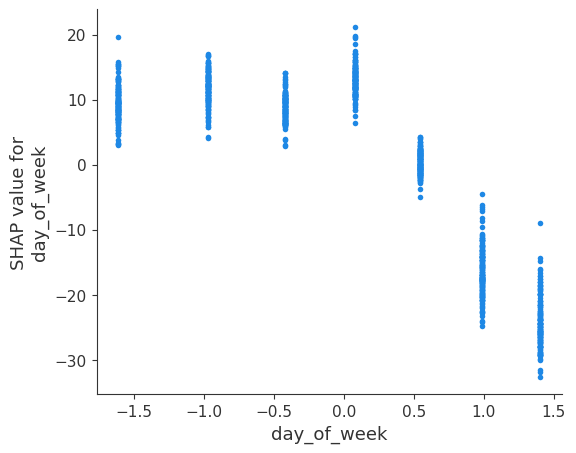

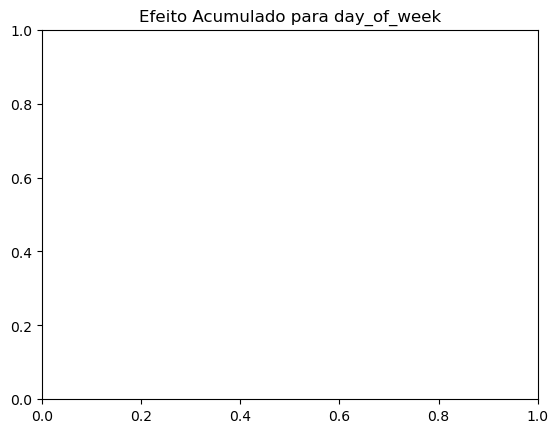

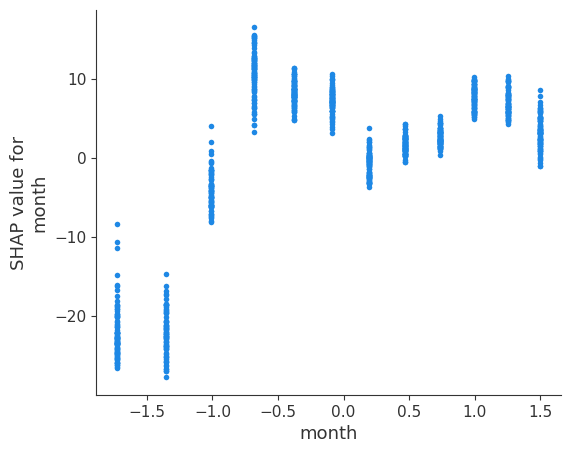

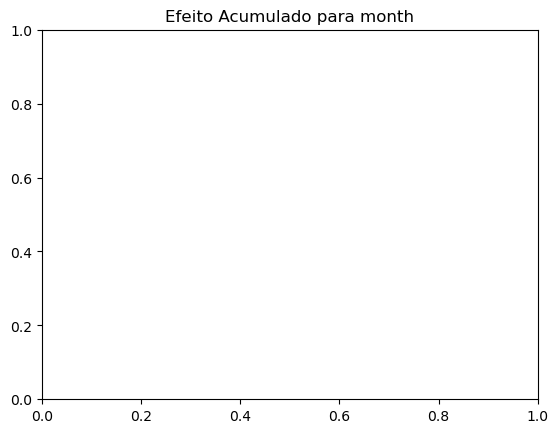

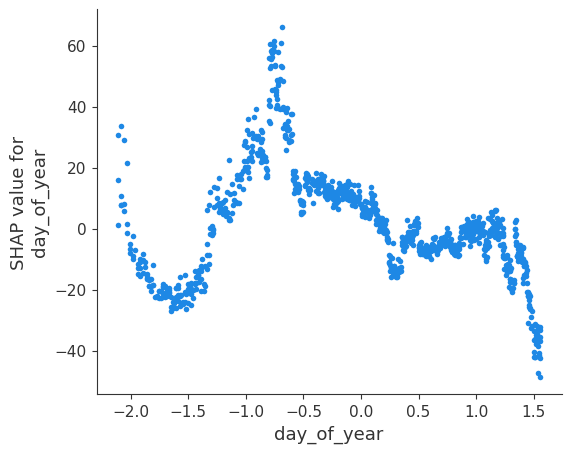

In [22]:
# Transformar X_train de volta em DataFrame para garantir os nomes das colunas
X_train_df = pd.DataFrame(X_train, columns=independent_vars)  # Converte X_train em DataFrame com nomes

# Inicializar o objeto explainer e calcular os valores SHAP
explainer = shap.Explainer(best_xgb_model, X_train_df)  # Cria o explainer SHAP
shap_values = explainer(X_train_df)  # Calcula os valores SHAP

# Gráficos de Dependência usando SHAP para as variáveis mais importantes
# Dependence plot para day_of_week
shap.dependence_plot("day_of_week", shap_values.values, X_train_df, interaction_index=None)  # Gráfico para day_of_week
plt.title("Efeito Acumulado para day_of_week")
plt.show()

# Dependence plot para month
shap.dependence_plot("month", shap_values.values, X_train_df, interaction_index=None)  # Gráfico para month
plt.title("Efeito Acumulado para month")
plt.show()

# Dependence plot para day_of_year
shap.dependence_plot("day_of_year", shap_values.values, X_train_df, interaction_index=None)

In [23]:
#Bloco 8 gerando gráficos

In [24]:
#1. Gráfico de Dispersão Real vs. Predito

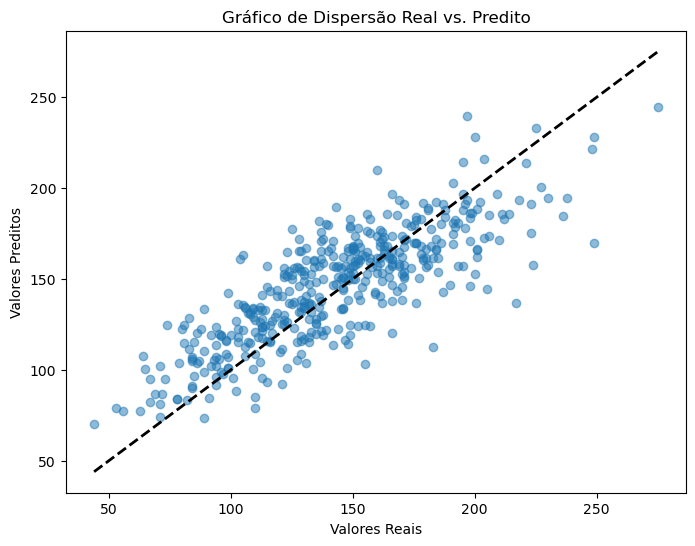

<Figure size 640x480 with 0 Axes>

In [118]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Gráfico de Dispersão Real vs. Predito")
plt.show()

# Salvar o gráfico como arquivo PNG
plt.savefig('grafico_dispersao.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# 2. Resíduos vs. Valores Reais


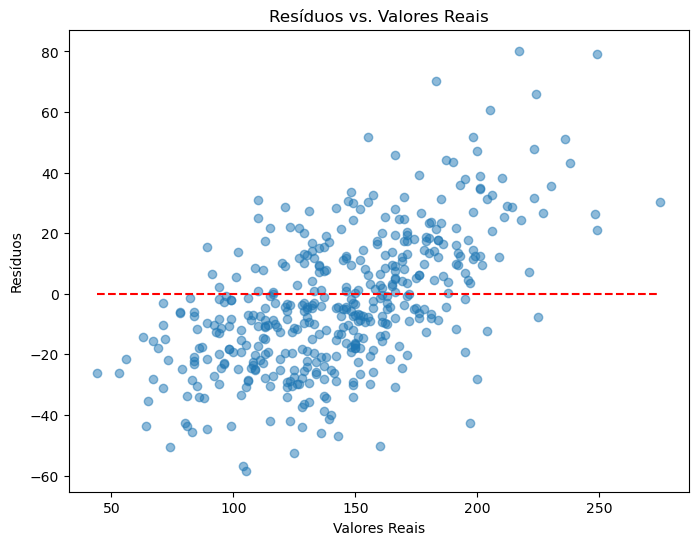

In [27]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.hlines(0, y_test.min(), y_test.max(), colors='r', linestyles='dashed')
plt.xlabel("Valores Reais")
plt.ylabel("Resíduos")
plt.title("Resíduos vs. Valores Reais")
plt.show()

In [28]:
# 3. Histograma dos Resíduos

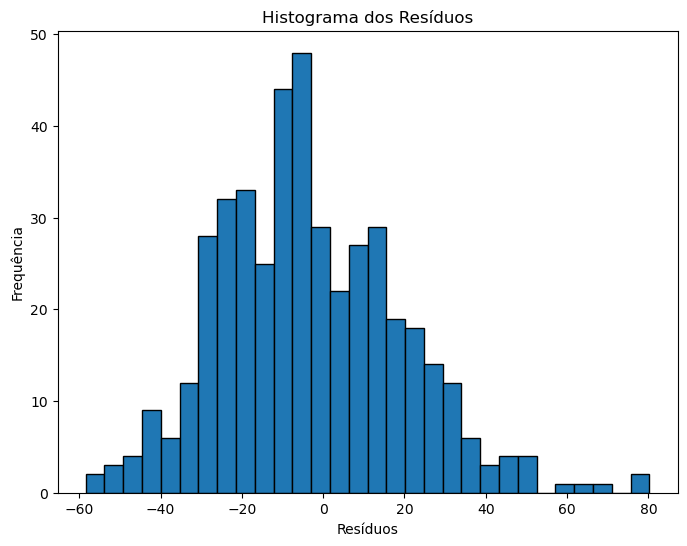

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Histograma dos Resíduos")
plt.show()

In [30]:
# 4. Curva de Aprendizado

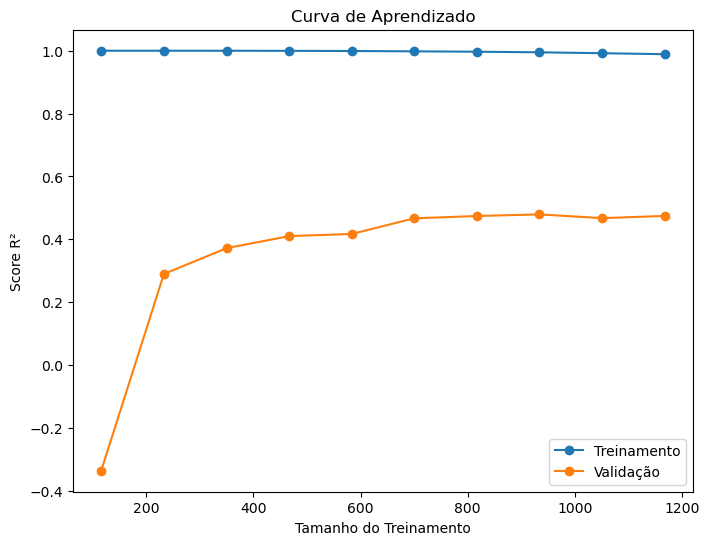

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_scaled, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Treinamento")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validação")
plt.xlabel("Tamanho do Treinamento")
plt.ylabel("Score R²")
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

In [32]:
# 5. Importância das Variáveis (XGBoost)

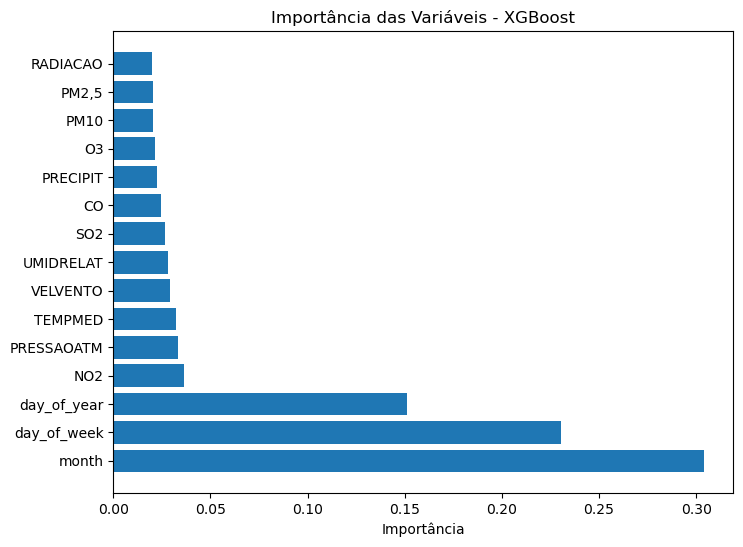

In [33]:
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importância")
plt.title("Importância das Variáveis - XGBoost")
plt.show()

In [34]:
# 6. Matriz de Correlação entre as Variáveis Independentes

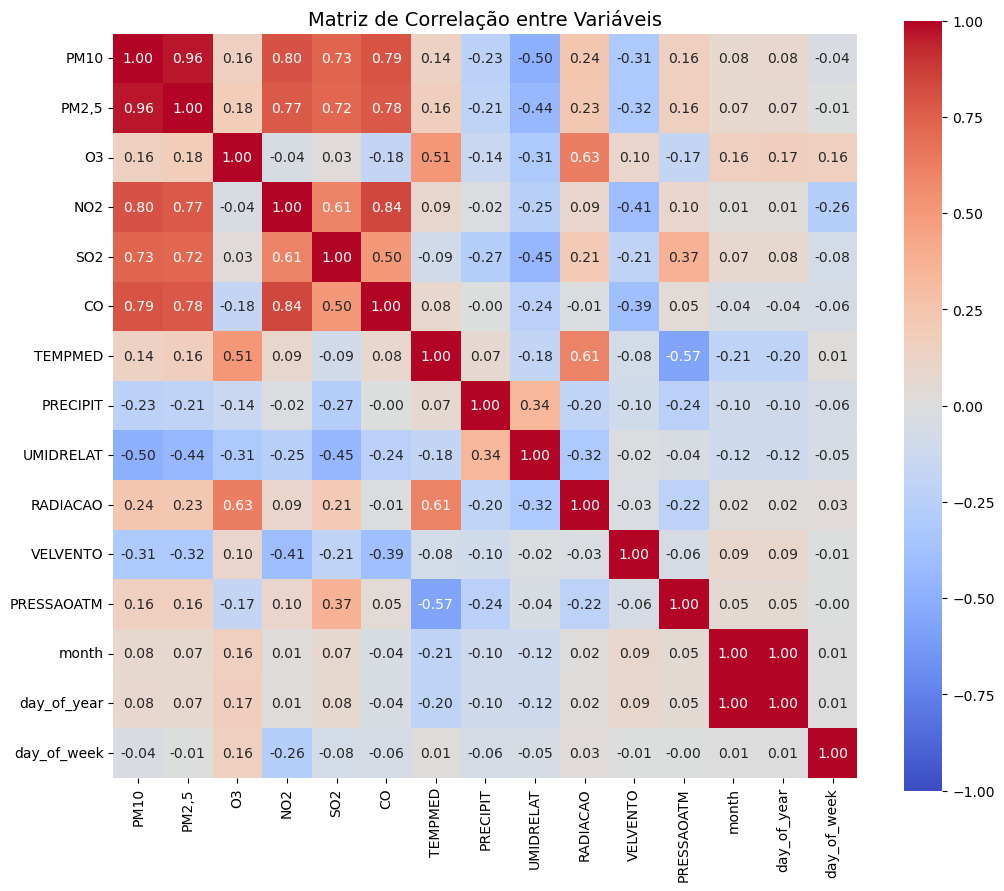

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gerar a matriz de correlação
correlation_matrix = X.corr()

# Configurar o tamanho da figura para maior legibilidade
plt.figure(figsize=(12, 10))  # Aumente os valores de largura e altura conforme necessário

# Criar o heatmap da matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 10})

# Ajustar o título do gráfico
plt.title("Matriz de Correlação entre Variáveis", fontsize=14)

# Salvar o gráfico automaticamente
plt.savefig("matriz_correlacao.png", dpi=300, bbox_inches='tight')  # Salva o gráfico como PNG com alta resolução

# Mostrar o gráfico na tela
plt.show()


In [122]:
import os
print(os.getcwd())


C:\Users\Windows\0. Doutorado


In [36]:
# 7. Heatmap de Parâmetros do GridSearch

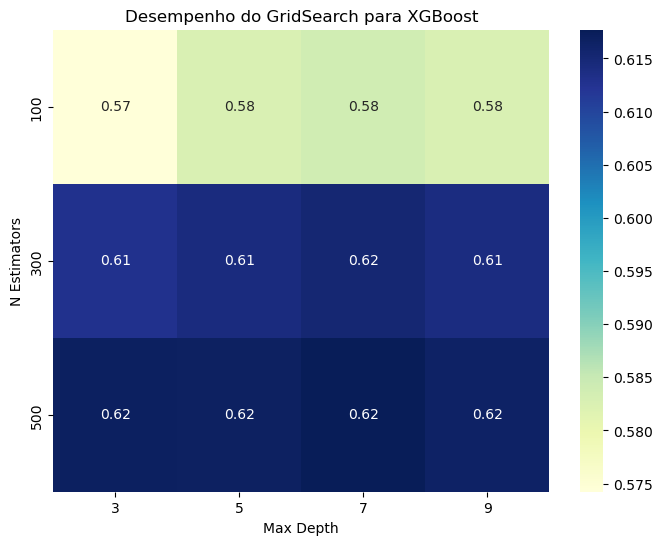

In [37]:
results = pd.DataFrame(grid_search_xgb.cv_results_)
heatmap_data = results.pivot_table(
    index='param_n_estimators', columns='param_max_depth', values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Desempenho do GridSearch para XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("N Estimators")
plt.show()

In [38]:
# 8. Análise de Sensibilidade

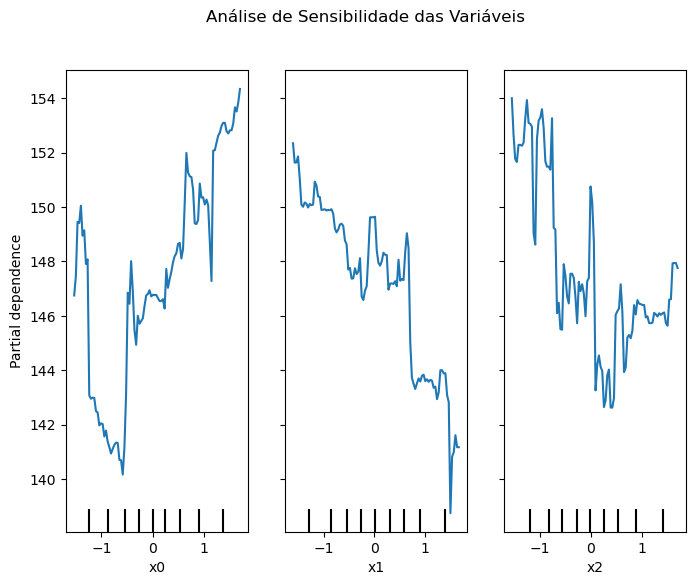

In [39]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_xgb_model, X_train, features=[0, 1, 2], ax=ax)
plt.suptitle("Análise de Sensibilidade das Variáveis")
plt.show()

In [40]:
# 9. Partial Dependence Plot (PDP)

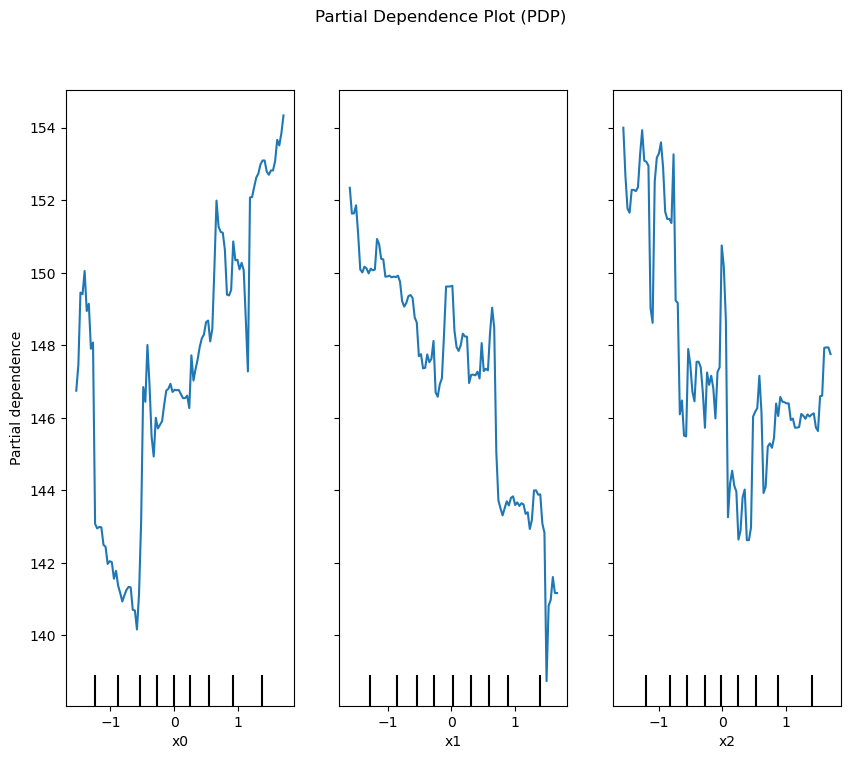

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
PartialDependenceDisplay.from_estimator(best_xgb_model, X_train, features=[0, 1, 2], ax=ax)
plt.suptitle("Partial Dependence Plot (PDP)")
plt.show()


In [42]:
# 10. SHAP Summary Plot, Bar Plot e Force Plot

 96%|=================== | 985/1022 [00:25<00:00]       

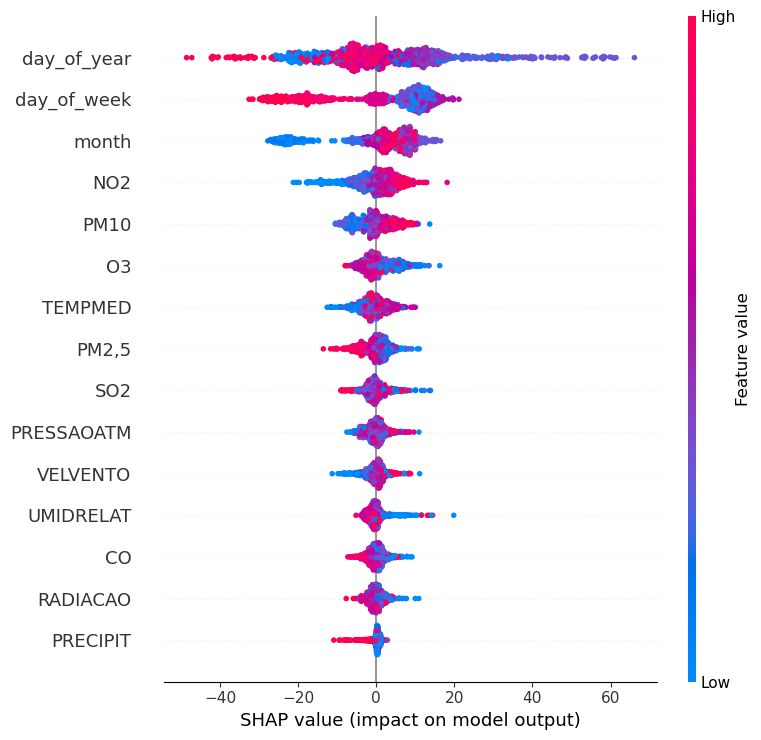

In [43]:
explainer = shap.Explainer(best_xgb_model, X_train_df)
shap_values = explainer(X_train_df)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train_df)

In [44]:
#11. SHAP Bar Plot

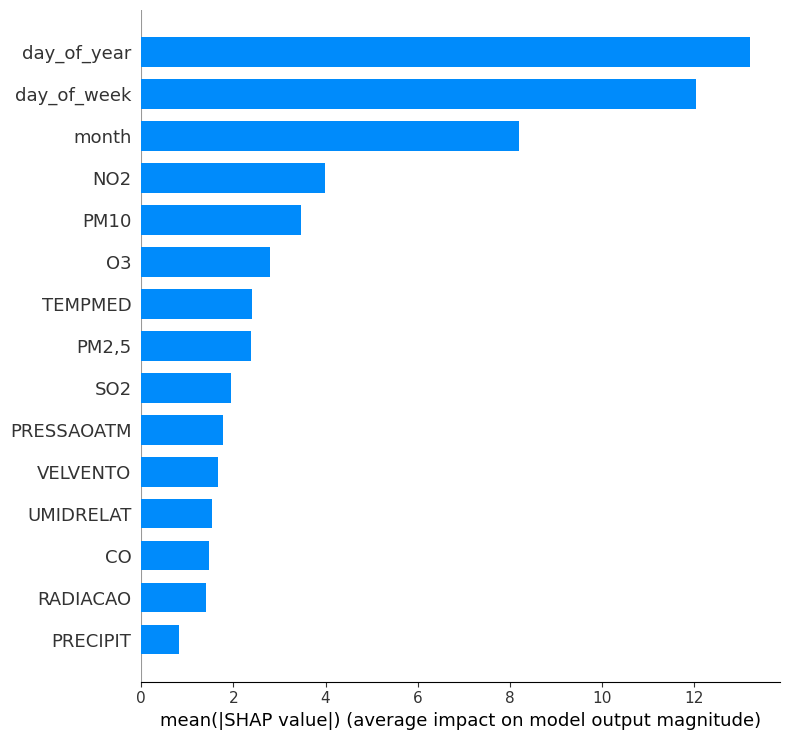

In [45]:
shap.summary_plot(shap_values, X_train_df, plot_type="bar")

In [46]:
#12. SHAP Force Plot para uma previsão específica

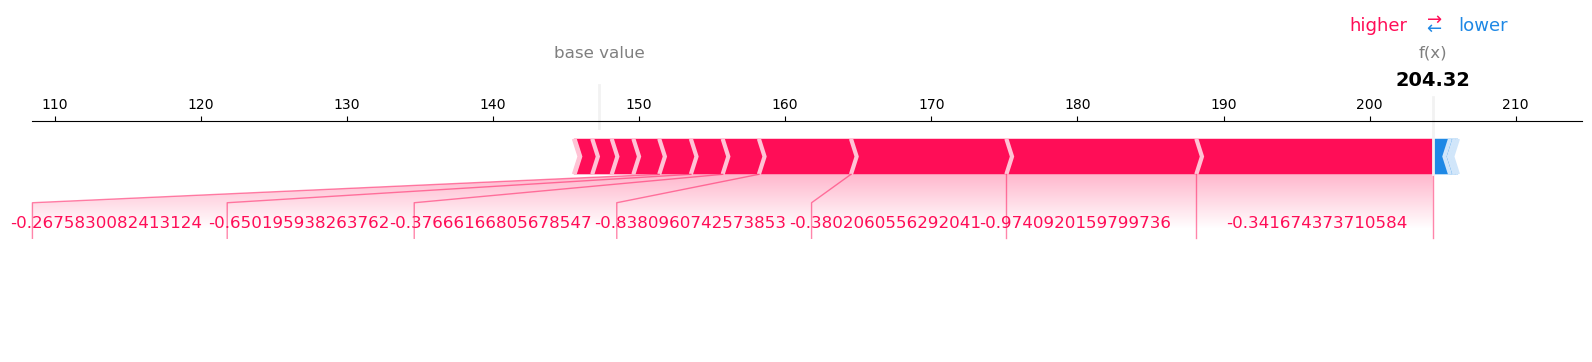

In [124]:
shap.force_plot(explainer.expected_value, shap_values[0].values, shap_values[0].data, matplotlib=True)

In [50]:
#13. Boxplot (Valores Reais vs Preditos)

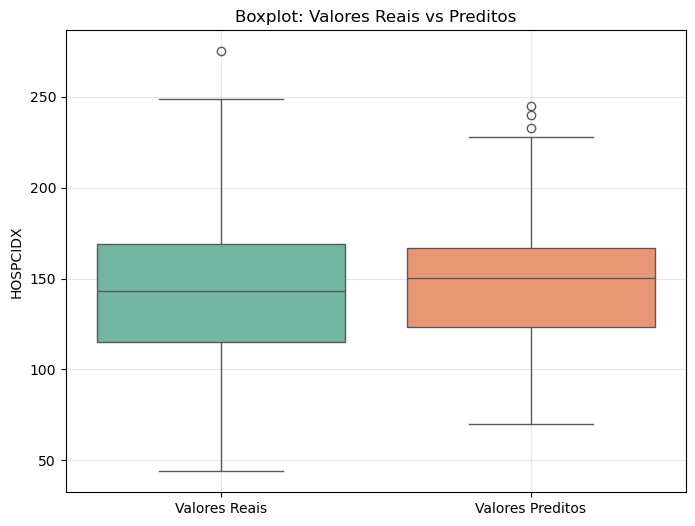

In [51]:
import seaborn as sns

# Criar DataFrame para o Boxplot
import pandas as pd
boxplot_data = pd.DataFrame({'Valores Reais': y_test, 'Valores Preditos': y_pred})

# Gráfico de Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=boxplot_data, orient="v", palette="Set2")
plt.title("Boxplot: Valores Reais vs Preditos")
plt.ylabel("HOSPCIDX")
plt.grid(alpha=0.3)
plt.show()


In [52]:
#14. Erros ao Longo do Tempo

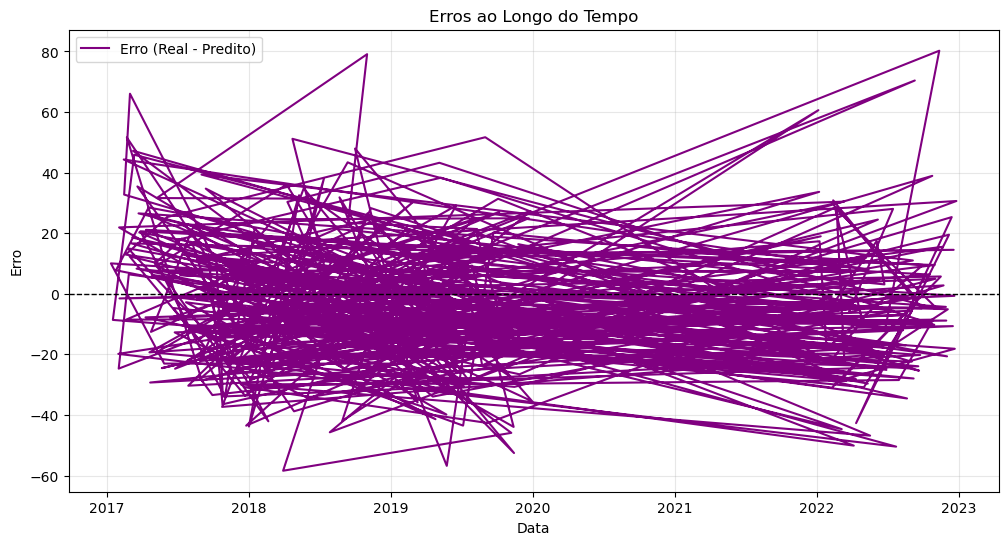

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test - y_pred, label="Erro (Real - Predito)", color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Data")
plt.ylabel("Erro")
plt.title("Erros ao Longo do Tempo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [54]:
#15. Histograma de Erros

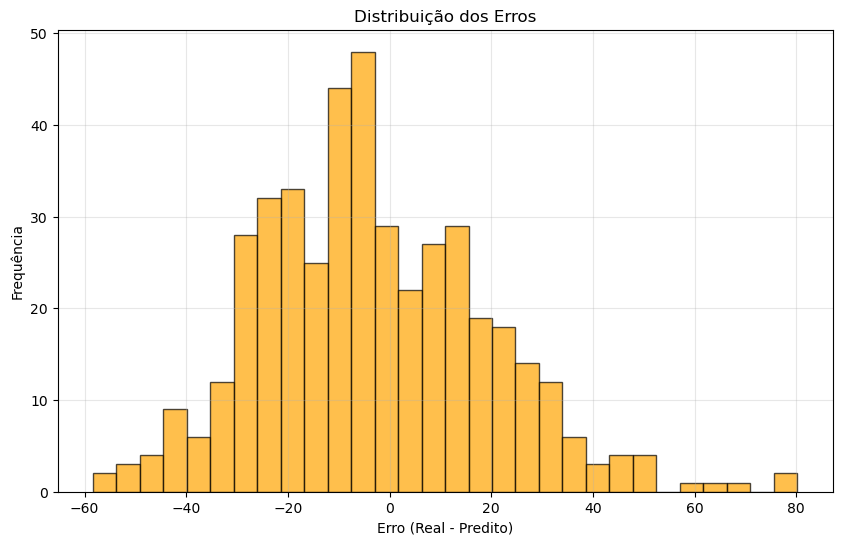

In [55]:
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("Erro (Real - Predito)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Erros")
plt.grid(alpha=0.3)
plt.show()


In [56]:
#16. Efeito Acumulado Local (ALE) com shap.dependence_plot

 98%|===================| 998/1022 [00:20<00:00]        

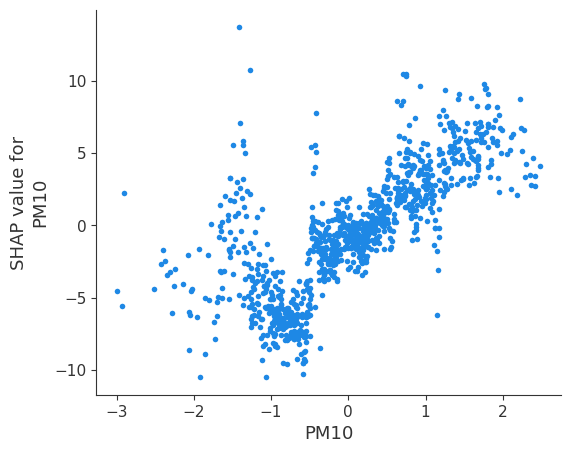

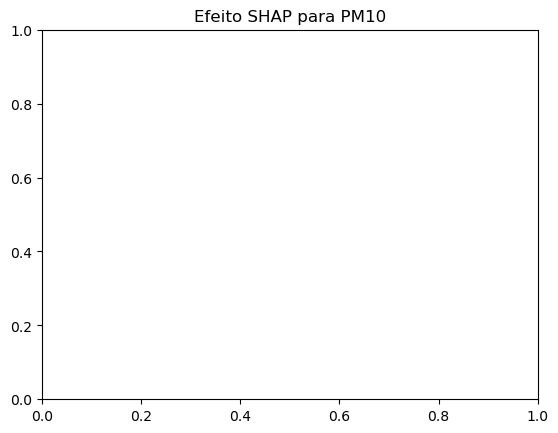

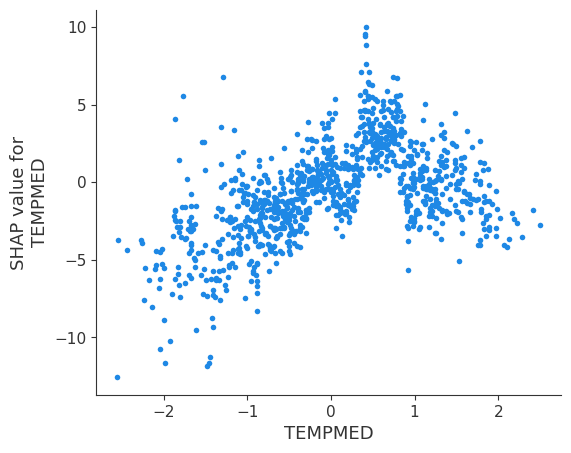

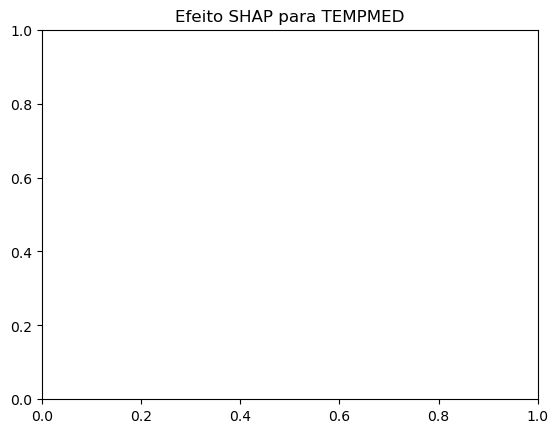

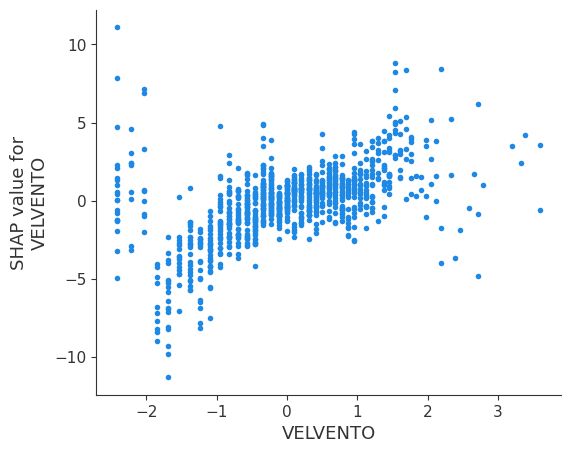

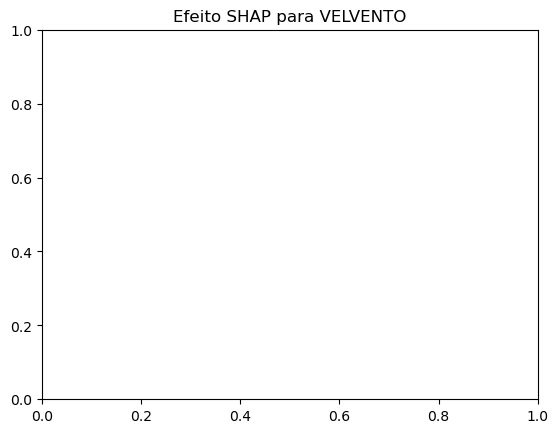

In [57]:
import shap
import matplotlib.pyplot as plt

# Gerar explicador SHAP para o modelo ajustado
explainer = shap.Explainer(best_xgb_model, X_train_df)
shap_values = explainer(X_train_df)

# Variáveis de interesse
variables = ["PM10", "TEMPMED", "VELVENTO"]

# Gerar gráficos SHAP para as variáveis de interesse
for var in variables:
    if var in X_train_df.columns:
        shap.dependence_plot(var, shap_values.values, X_train_df, interaction_index=None)
        plt.title(f"Efeito SHAP para {var}")
        plt.show()
    else:
        print(f"Variável {var} não encontrada em X_train_df.")


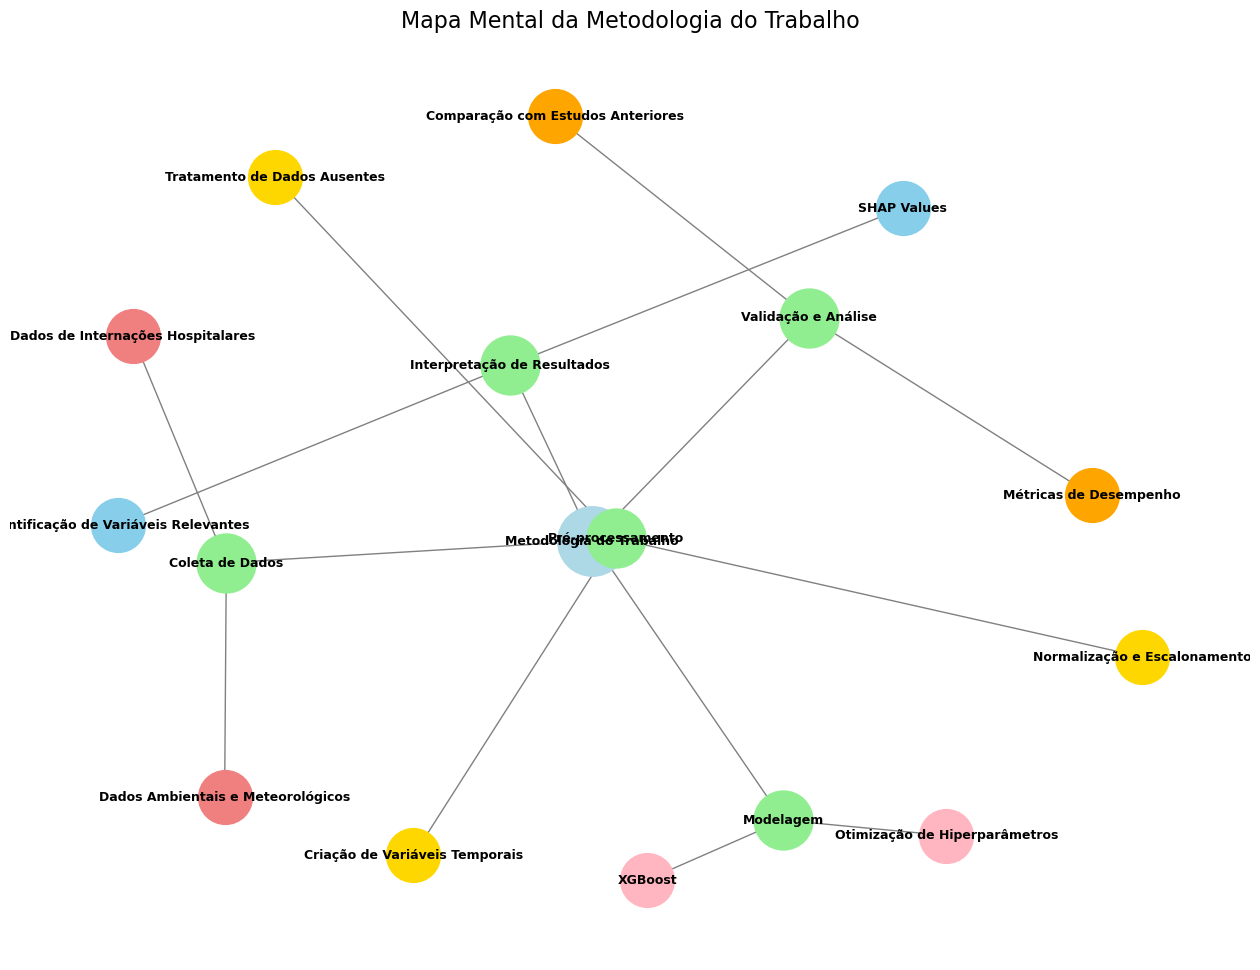

O mapa mental foi salvo como 'mapa_mental_metodologia_colorido_ajustado.png'.


In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Criar o grafo
G = nx.DiGraph()

# Adicionando os nós principais e subnós
nodes = {
    "Metodologia do Trabalho": {"color": "lightblue", "size": 2500},
    "Coleta de Dados": {"color": "lightgreen", "size": 1800},
    "Dados Ambientais e Meteorológicos": {"color": "lightcoral", "size": 1500},
    "Dados de Internações Hospitalares": {"color": "lightcoral", "size": 1500},
    "Pré-processamento": {"color": "lightgreen", "size": 1800},
    "Tratamento de Dados Ausentes": {"color": "gold", "size": 1500},
    "Normalização e Escalonamento": {"color": "gold", "size": 1500},
    "Criação de Variáveis Temporais": {"color": "gold", "size": 1500},
    "Modelagem": {"color": "lightgreen", "size": 1800},
    "XGBoost": {"color": "lightpink", "size": 1500},
    "Otimização de Hiperparâmetros": {"color": "lightpink", "size": 1500},
    "Interpretação de Resultados": {"color": "lightgreen", "size": 1800},
    "SHAP Values": {"color": "skyblue", "size": 1500},
    "Identificação de Variáveis Relevantes": {"color": "skyblue", "size": 1500},
    "Validação e Análise": {"color": "lightgreen", "size": 1800},
    "Métricas de Desempenho": {"color": "orange", "size": 1500},
    "Comparação com Estudos Anteriores": {"color": "orange", "size": 1500}
}

edges = [
    ("Metodologia do Trabalho", "Coleta de Dados"),
    ("Coleta de Dados", "Dados Ambientais e Meteorológicos"),
    ("Coleta de Dados", "Dados de Internações Hospitalares"),
    ("Metodologia do Trabalho", "Pré-processamento"),
    ("Pré-processamento", "Tratamento de Dados Ausentes"),
    ("Pré-processamento", "Normalização e Escalonamento"),
    ("Pré-processamento", "Criação de Variáveis Temporais"),
    ("Metodologia do Trabalho", "Modelagem"),
    ("Modelagem", "XGBoost"),
    ("Modelagem", "Otimização de Hiperparâmetros"),
    ("Metodologia do Trabalho", "Interpretação de Resultados"),
    ("Interpretação de Resultados", "SHAP Values"),
    ("Interpretação de Resultados", "Identificação de Variáveis Relevantes"),
    ("Metodologia do Trabalho", "Validação e Análise"),
    ("Validação e Análise", "Métricas de Desempenho"),
    ("Validação e Análise", "Comparação com Estudos Anteriores")
]

# Adicionar nós e arestas ao grafo
for node, attrs in nodes.items():
    G.add_node(node, **attrs)
G.add_edges_from(edges)

# Configuração de layout
pos = nx.spring_layout(G, seed=42, k=0.3)

# Criar o gráfico
plt.figure(figsize=(16, 12))
for node, attr in G.nodes(data=True):
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=attr["color"], node_size=attr["size"])
nx.draw_networkx_edges(G, pos, edge_color="gray", arrowsize=15, arrowstyle="-|>")
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold", verticalalignment="center")

plt.title("Mapa Mental da Metodologia do Trabalho", fontsize=16)
plt.axis("off")

# Salvar o gráfico
plt.savefig("mapa_mental_metodologia_colorido_ajustado.png", format="png", dpi=300)
plt.show()

print("O mapa mental foi salvo como 'mapa_mental_metodologia_colorido_ajustado.png'.")



